In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Dense, Input, Flatten, Reshape
from tensorflow.keras.datasets.mnist import load_data
import tensorflow.keras.backend as K

import pandas as pd
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = load_data()
x_train, x_test = x_train.astype("float32") / 255., x_test.astype("float32") / 255.
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [2]:
## Create sampling layer
class Sampling(Layer):
    def call(self, input):
        mean, log_var = input
        return K.random_normal(tf.shape(log_var), mean, K.exp(log_var / 2))

### start creating the model

K.clear_session()

## encoder
coding_size = 10
input = Input(shape=[28, 28])
z = Flatten()(input)
z = Dense(128, activation="selu")(z)
z = Dense(64, activation="selu")(z)
coding_mean = Dense(coding_size)(z)
coding_log_var = Dense(coding_size)(z)
codings = Sampling()([coding_mean, coding_log_var])

encoder = Model(inputs=[input], outputs=[coding_mean, coding_log_var, codings])

## decoder
decoder_input = Input(shape=[coding_size])
x = Dense(64, activation="selu")(decoder_input)
x = Dense(128, activation="selu")(x)
x = Dense(28 * 28, activation="sigmoid")(x)
output = Reshape((28, 28))(x)

decoder = Model(inputs=[decoder_input], outputs=[output])

## Full model
_, _, codings = encoder(input)
reconstructions = decoder(codings)

variational_ae = Model(inputs=[input], outputs=[reconstructions])

variational_ae.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
model (Functional)           [(None, 10), (None, 10),  110036    
_________________________________________________________________
model_1 (Functional)         (None, 28, 28)            110160    
Total params: 220,196
Trainable params: 220,196
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
469/469 [==============================] - 5s 5ms/step - loss: 0.2757 - val_loss: 0.1827
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1813 - val_loss: 0.1695
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1686 - val_loss: 0.1623
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1621 - val_loss: 0.1590
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1578 - val_loss: 0.1540
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1552 - val_loss: 0.1530
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1533 - val_loss: 0.1503
Epoch 8/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1516 - val_loss: 0.1494
Epoch 9/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1504 - val_loss: 0.1492
Epoch 10/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1493 - val_loss: 0.1476

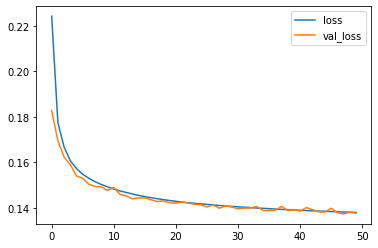

In [3]:
## kullback libler loss
latent_loss = -0.5 * tf.reduce_sum(1 + coding_log_var - tf.exp(coding_log_var) - tf.square(coding_mean), axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

history = variational_ae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

pd.DataFrame(history.history).plot()
plt.show()


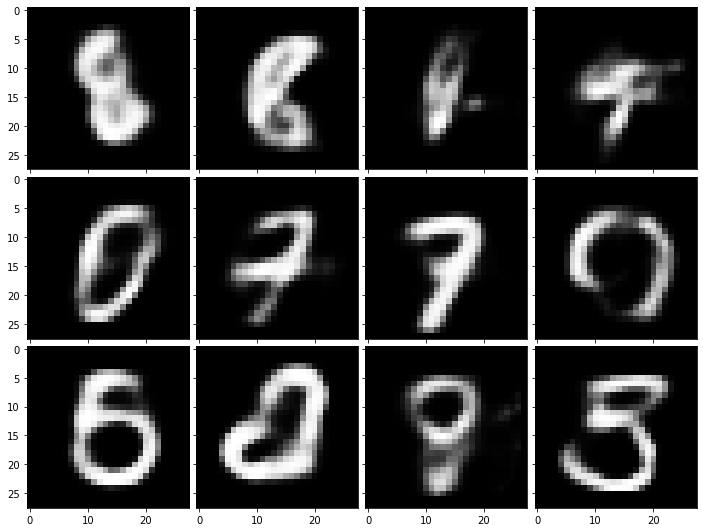

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

random_codings = tf.random.normal(shape=[12, coding_size])
images = decoder(random_codings).numpy()

fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(3, 4),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap="gray")

plt.show()

(60000, 10)
(60000, 2)


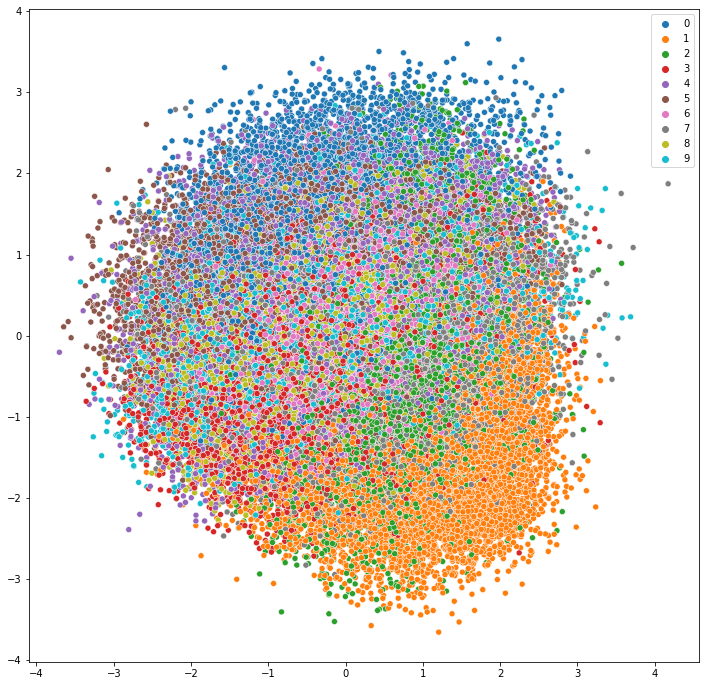

In [17]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

reducer = PCA(2)

_, _, z = encoder(x_train)
print(z.shape)
z_2d = reducer.fit_transform(z)
print(z_2d.shape)
plt.figure(figsize=(12, 12))
sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=y_train, palette="tab10")
plt.show()

In [15]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)